In [ ]:
!pip install tf-nightly-tpu

In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 27.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [10]:
import cv2
import numpy as np
import mediapipe as mp

# Initialize MediaPipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def detect_mouth(image):
    """
    Detect the mouth region in a given image containing a face.

    Args:
        image (numpy.ndarray): Input image containing a face.

    Returns:
        dict: Dictionary containing the mouth landmarks and bounding box.
    """
    # Process the image to get face landmarks
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_face_landmarks:
        # Get the landmarks for the first detected face
        face_landmarks = results.multi_face_landmarks[0]

        # Find the mouth landmarks
        mouth_landmarks = []
        for id, landmark in enumerate(face_landmarks.landmark):
            if id in [60, 61, 62, 63, 64, 65, 66, 67]:
                x = int(landmark.x * image.shape[1])
                y = int(landmark.y * image.shape[0])
                mouth_landmarks.append((x, y))

        # Calculate the bounding box of the mouth
        x, y, width, height = cv2.boundingRect(np.array(mouth_landmarks))

        return {
            "landmarks": mouth_landmarks,
            "bbox": (x, y, width, height)
        }

    return None

def replace_teeth(image, teeth_image):
    """
    Replace the teeth in a given face image with a new teeth image.

    Args:
        image (numpy.ndarray): Input image containing a face.
        teeth_image (numpy.ndarray): Image of the new teeth to be inserted.

    Returns:
        numpy.ndarray: Image with the teeth replaced.
    """
    # Detect the mouth region
    mouth_info = detect_mouth(image)

    if mouth_info:
        mouth_landmarks = mouth_info["landmarks"]
        x, y, width, height = mouth_info["bbox"]

        # Resize the teeth image to match the mouth region
        resized_teeth = cv2.resize(teeth_image, (width, height))

        # Create a mask for the teeth region
        teeth_mask = np.zeros_like(image)

        # Paste the resized teeth image onto the mask
        teeth_mask[y:y+height, x:x+width] = resized_teeth

        # Blend the teeth mask with the original image
        result = cv2.addWeighted(image, 1, teeth_mask, 1, 0)
        return result

    return image

input_image = cv2.imread('beatiful-smile-african-am-woman.jpg', cv2.IMREAD_COLOR)
teeth_image = cv2.imread('shiny-white-smile-JNeRbL.jpeg', cv2.IMREAD_COLOR)

output_image = replace_teeth(input_image, teeth_image)
cv2.imwrite('output_image.jpg', output_image)

True

In [ ]:
import os
reference_folder = 'drive/MyDrive/Thesis/VPR_India/Reference_dataset'
files = os.listdir(reference_folder)
print(len(files))

2500


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.models as models
import keras.utils as image
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import euclidean_distances

hognet_model = models.load_model("drive/MyDrive/Thesis/hog_predictor_additional_con_pool.hdf5")
hognet_model.summary()
#vpr_model = Model(inputs=hognet_model.input, outputs=hognet_model.get_layer('flatten').output) ## It is actually the features of the second pooling layer
#vpr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 62, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 pool3 (MaxPooling2D)        (None, 30, 30, 32)        0         
                                                                 
 flatten (Flatten)           (None, 28800)             0

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.models as models
import keras.utils as image
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import euclidean_distances
from keras.layers import Flatten, Dense, Lambda
#from tensorflow.keras.applications import VGG16

hognet_model = models.load_model("drive/MyDrive/Thesis/Ali_Abdo/hog_predictor_vgg16_old.hdf5")
#hognet_model.summary()
#vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
#vpr_model = Model(inputs=vgg16.input, outputs=Flatten()(vgg16.get_layer('block5_pool').output)) ## It is actually the features of the second pooling layer
#vpr_model = Model(inputs=hognet_model.input, outputs=Flatten()(hognet_model.get_layer('pool2').output))
vpr_model = hognet_model
vpr_model.summary()

def numerical_sort(value):
    parts = value.split('.')
    return int(parts[0])

from skimage.transform import resize
from skimage.feature import hog
from skimage import color

def find_hog(image):
    input_image = cv2.imread(image, cv2.IMREAD_COLOR)
    input_image = tf.image.resize(input_image, (256, 256))
    resized_img = resize(color.rgb2gray(input_image), (256, 256))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(32, 32),
                        cells_per_block=(2, 2), visualize=True, channel_axis=None)
    #fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(32, 32),
    #                    cells_per_block=(2, 2), visualize=True, channel_axis=None)

    #return color.gray2rgb(hog_image, channel_axis= 2)
    return fd

def extract_features(input_image):
    img = cv2.imread(input_image, cv2.IMREAD_COLOR)
    resized_img = tf.image.resize(img, (256, 256))
    input_set = [resized_img]
    input_set = tf.convert_to_tensor(input_set, dtype=tf.int16)
    print(input_set)
    return vpr_model.predict(input_set)

'''
def extract_features(image_path):
    #img_array = find_hog(image_path)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    #img_array = tf.image.resize(img, (256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    features = vpr_model.predict(img_array)
    return features
'''
reference_folder = 'drive/MyDrive/Thesis/Nordland/Summer'
#reference_folder = 'drive/MyDrive/Thesis/San_Francisco_eXtra_Large/queries_v1'
files = os.listdir(reference_folder)
sorted_files = sorted(files, key=numerical_sort)
files = sorted_files[:2000]

# Reference dataset (database) images
reference_images = [os.path.join(reference_folder, file) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

v = extract_features(reference_images[0])
v2 = extract_features(reference_images[500])
print(v)
print(v2)
d = euclidean_distances(v, v2)[0][0]
print(d)
vv = find_hog(reference_images[0]).reshape(1, 1764)
vv2 = find_hog(reference_images[500]).reshape(1, 1764)
print(vv)
print(vv2)
d = euclidean_distances(vv, vv2)[0][0]
print(d)

d = euclidean_distances(v, vv)[0][0]
print(d)

d = euclidean_distances(v2, vv2)[0][0]
print(d)

'''
# Extract features from reference images
reference_features = [extract_features(image_path) for image_path in reference_images]

np.save('drive/MyDrive/Thesis/Nordland/reference_features_hog_predictor_additional_con_pool_pool2_8000.npy', reference_features)
'''

'''
reference_features = np.load('drive/MyDrive/Thesis/Nordland/reference_features_hog_predictor_additional_con_pool_pool2_8000.npy')
#reference_features = reference_features.reshape(8000, 1, 1764)
print (reference_features.shape)


# Query image
query_folder = 'drive/MyDrive/Thesis/Nordland/Spring'
#query_folder = 'drive/MyDrive/Thesis/Nordland/Summer'

files = os.listdir(query_folder)
sorted_files = sorted(files, key=numerical_sort)
files = sorted_files[:2000]

correct_predictions = 0
correct_image_pair_predictions = []
incorrect_image_pair_predictions = []
# Extract features from query image
for query_image in files:
    file = query_image
    query_image = os.path.join(query_folder, query_image)
    query_features = extract_features(query_image)
    #query_features = query_features.reshape(1, 1764)

    # Calculate Euclidean distances between query features and reference features
    query_index = int(file.rstrip(".png"))
    distances = [euclidean_distances(query_features, ref_features)[0][0] for ref_features in reference_features[:2000]]

    # Find the index of the closest image (smallest distance)
    closest_index = np.argmin(distances)
    closest_image_path = reference_images[closest_index]
    print(query_index)
    print(closest_index)
    #if abs(query_index - start - closest_index) <= 5:
    if abs(query_index - closest_index - 0) <= 3:
        correct_predictions += 1
        correct_image_pair_predictions.append([query_image , closest_image_path])
    else:
        incorrect_image_pair_predictions.append([query_image , closest_image_path])

print (correct_predictions)

# Display query and closest image
query_img = plt.imread(correct_image_pair_predictions[10][0])
closest_img = plt.imread(correct_image_pair_predictions[10][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()

# Display another query and closest image
query_img = plt.imread(correct_image_pair_predictions[50][0])
closest_img = plt.imread(correct_image_pair_predictions[50][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 fc1 (Dense)                 (None, 4096)              134221824 
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 hog_vector (Dense)          (None, 1764)              7227108   
                                                                 
Total params: 172944932 (659.73 MB)
Trainable params: 172944932 (659.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
tf.Tensor(

1/1 [==============================] - 1s 922ms/step
tf.Tensor(
[[[[204 197 189]
   [204 197 189]
   [203 196 188]
   ...
   [200 194 180]
   [207 198 186]
   [213 203 191]]

  [[202 195 187]
   [203 196 188]
   [204 197 189]
   ...
   [200 193 179]
   [204 196 184]
   [212 202 191]]

  [[203 196 188]
   [203 196 188]
   [203 196 188]
   ...
   [203 194 181]
   [206 198 185]
   [212 204 191]]

  ...

  [[ 39  84  60]
   [ 40  83  60]
   [ 39  84  60]
   ...
   [ 36  58  55]
   [ 37  61  58]
   [ 34  61  55]]

  [[ 36  83  58]
   [ 36  84  58]
   [ 38  85  61]
   ...
   [ 38  60  57]
   [ 36  59  55]
   [ 37  64  58]]

  [[ 36  83  58]
   [ 35  84  58]
   [ 37  86  61]
   ...
   [ 40  62  59]
   [ 38  61  58]
   [ 37  64  58]]]], shape=(1, 256, 256, 3), dtype=int16)
1/1 [==============================] - 1s 743ms/step
[[0.18386203 0.0809512  0.0767359  ... 0.08636889 0.0752788  0.10727581]]
[[0.18386203 0.0809512  0.0767359  ... 0.08636889 0.0752788  0.10727581]]
0.0
[[0.02990721 0.0170

'\nreference_features = np.load(\'drive/MyDrive/Thesis/Nordland/reference_features_hog_predictor_additional_con_pool_pool2_8000.npy\')\n#reference_features = reference_features.reshape(8000, 1, 1764)\nprint (reference_features.shape)\n\n\n# Query image\nquery_folder = \'drive/MyDrive/Thesis/Nordland/Spring\'\n#query_folder = \'drive/MyDrive/Thesis/Nordland/Summer\'\n\nfiles = os.listdir(query_folder)\nsorted_files = sorted(files, key=numerical_sort)\nfiles = sorted_files[:2000]\n\ncorrect_predictions = 0\ncorrect_image_pair_predictions = []\nincorrect_image_pair_predictions = []\n# Extract features from query image\nfor query_image in files:\n    file = query_image\n    query_image = os.path.join(query_folder, query_image)\n    query_features = extract_features(query_image)\n    #query_features = query_features.reshape(1, 1764)\n\n    # Calculate Euclidean distances between query features and reference features\n    query_index = int(file.rstrip(".png"))\n    distances = [euclidean_dis

In [ ]:
import torch
torch.cuda.is_available()

True

PartialNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
(8000, 1, 28800)
6000
0
6001
1
6002
2
6003
3
6004
4
6005
5
6006
6
6007
7
6008
8
6009
9
6010
10
6011
11
6012
12
6013
13
6014
14
6015
15
6016
16
6017
18
6018
18
6019
19
6020
20
6021
310
6022
22
6023
27
6024
27
6025
27
6026
1404
6027
309
6028
310
6029
635
6030
635
6031
636
6032
32
6033
33
6034
34
6035
35
6036
208
6037
37
6038
921
6039
647
6040
1663
6041
1658
6042
42
6043
647
6044
44
6045
1413
6046
921
6047
921
6048
921
6049
647
6050
50
6051
51
6052
210
6053
1664
6054
647
6055
647
6056
647
6057
635


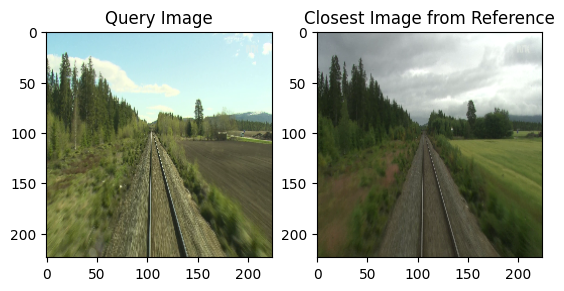

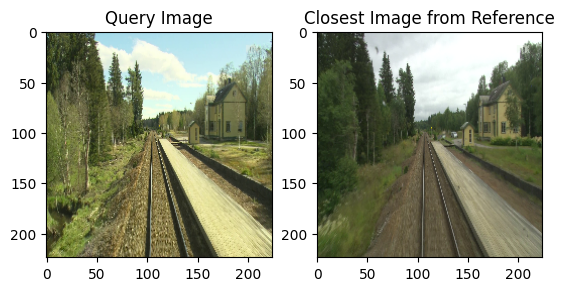

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.models as models
import keras.utils as image
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances
import torch
import torch.nn as nn
from skimage import data
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import euclidean_distances
from skimage import color
from skimage.feature import hog

class PartialNet(nn.Module):
    def __init__(self, len_hog_vector):
        super(PartialNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        #self.fc1 = nn.Linear(30 * 30 * 32, 4096)
        #self.fc2 = nn.Linear(4096, 4096)
        #self.hog_vector = nn.Linear(4096, len_hog_vector)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.pool3(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        #x = nn.functional.relu(self.fc1(x))
        #x = nn.functional.relu(self.fc2(x))
        #x = self.hog_vector(x)
        return x

partial_model = PartialNet(1764)

print(partial_model)
partial_model.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_3Conv3Pool_1764_v2.pth"), strict=False)
#partial_model.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_3Conv3Pool_1764_v4.pth"))
partial_model.eval()

def numerical_sort(value):
    parts = value.split('.')
    return int(parts[0])

tensor_transform = transforms.Compose([transforms.ToTensor()])
def extract_features(input_image):
    image = cv2.imread(input_image, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(image, (256, 256))
    #input_set = [resized_img]
    #input_set = tf.convert_to_tensor(input_set, dtype=tf.int16)
    #print(input_set)
    with torch.no_grad():
      hog_pred = partial_model(tensor_transform(resized_img).view(1,3,256,256))
    #hog_pred = torch.flatten(hog_pred, 1)
    return hog_pred.detach().numpy()

def find_hog(image):
    input_image = cv2.imread(image, cv2.IMREAD_COLOR)
    #input_image = tf.image.resize(input_image, (256, 256))
    resized_img = color.rgb2gray(input_image)
    fd = hog(resized_img, orientations=9, pixels_per_cell=(32, 32), cells_per_block=(1, 1))
    return fd.reshape(1, 441)

reference_folder = 'drive/MyDrive/Thesis/Nordland/Summer'

files = os.listdir(reference_folder)
sorted_files = sorted(files, key=numerical_sort)
files = sorted_files[6000:8000]

# Reference dataset (database) images
reference_images = [os.path.join(reference_folder, file) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
'''
# Extract features from reference images
reference_features = [extract_features(image_path) for image_path in reference_images]
#reference_features = [find_hog(image_path) for image_path in reference_images]

np.save('drive/MyDrive/Thesis/CIFAR_HOG/Nordland/reference_features_hog_3Conv3Pool_1764_pool3_v4_8000.npy', reference_features)
'''

reference_features = np.load('drive/MyDrive/Thesis/CIFAR_HOG/Nordland/reference_features_hog_3Conv3Pool_1764_pool3_v4_8000.npy')
#reference_features = reference_features.reshape(8000, 1, 1764)
print (reference_features.shape)

# Query image
query_folder = 'drive/MyDrive/Thesis/Nordland/Spring'
#query_folder = 'drive/MyDrive/Thesis/Nordland/Summer'

files = os.listdir(query_folder)
sorted_files = sorted(files, key=numerical_sort)
files = sorted_files[6000:8000]

correct_predictions = 0
correct_image_pair_predictions = []
incorrect_image_pair_predictions = []
# Extract features from query image
for query_image in files:
    file = query_image
    query_image = os.path.join(query_folder, query_image)
    query_features = extract_features(query_image)
    #query_features = find_hog(query_image)
    #query_features = query_features.reshape(1, 1764)

    # Calculate Euclidean distances between query features and reference features
    query_index = int(file.rstrip(".png"))
    distances = [euclidean_distances(query_features, ref_features)[0][0] for ref_features in reference_features[6000:8000]]

    # Find the index of the closest image (smallest distance)
    closest_index = np.argmin(distances)
    closest_image_path = reference_images[closest_index]
    print(query_index)
    print(closest_index)
    #if abs(query_index - start - closest_index) <= 5:
    if abs(query_index - closest_index - 6000) <= 3:
        correct_predictions += 1
        correct_image_pair_predictions.append([query_image , closest_image_path])
    else:
        incorrect_image_pair_predictions.append([query_image , closest_image_path])

print (correct_predictions)

# Display query and closest image
query_img = plt.imread(correct_image_pair_predictions[10][0])
closest_img = plt.imread(correct_image_pair_predictions[10][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()

# Display another query and closest image
query_img = plt.imread(correct_image_pair_predictions[50][0])
closest_img = plt.imread(correct_image_pair_predictions[50][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()


In [ ]:
import csv

# Specify the file path
csv_file = '/content/drive/MyDrive/Thesis/VPR_India/fixed_query_route1_forward_old.csv'

# Initialize an empty dictionary
csv_dict = {}

# Open the CSV file
with open(csv_file, mode='r', encoding='utf-8-sig') as file:
    # Create a CSV reader object
    reader = csv.DictReader(file)

    # Iterate through the rows
    for row in reader:
        # Assuming 'Column1' is the key and 'Column2' is the value
        key = row['cam3']
        value = row['coordinates']

        # Add the key/value pair to the dictionary
        csv_dict[key] = value

# Print the resulting dictionary
print(csv_dict)

{'1692870720342365829.png': '(17.4460224221741,78.3525771374629)', '1692870720440425954.png': '(17.4460224221741,78.3525771374629)', '1692870720539770237.png': '(17.4460224221741,78.3525771374629)', '1692870720641362074.png': '(17.4460224221741,78.3525771374629)', '1692870720741907637.png': '(17.4460224221741,78.3525771374629)', '1692870720839684931.png': '(17.4460224221741,78.3525771374629)', '1692870720938981755.png': '(17.4460224221741,78.3525771374629)', '1692870721039266111.png': '(17.4460224221741,78.3525771374629)', '1692870721139049142.png': '(17.4460224221741,78.3525771374629)', '1692870721238818696.png': '(17.4460224221741,78.3525771374629)', '1692870721339144250.png': '(17.4460224221741,78.3525771374629)', '1692870721439783626.png': '(17.4460224221741,78.3525771374629)', '1692870721538869187.png': '(17.4460224221741,78.3525771374629)', '1692870721638508618.png': '(17.4460224221741,78.3525771374629)', '1692870721739344984.png': '(17.4460224221741,78.3525771374629)', '16928707

In [ ]:
import os
original_string = "/content/drive/MyDrive/Thesis/VPR_India/1692870720342365829.png"
prefix_to_remove = "/content/drive/MyDrive/Thesis/VPR_India" + "/"

result = original_string.removeprefix(prefix_to_remove)
print(result)

os.remove('/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692871517442897369.png')

1692870720342365829.png


Streaming output truncated to the last 5000 lines.
1644
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870891672234857.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692871070192070790.png
(17.4509164181709, 78.3632032334955)
(17.4674717797634, 78.3668809664995)
737
1645
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692871410354783077.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870923939443375.png
(17.4911648422769, 78.3533655545995)
(17.4539284924898, 78.3635702854982)
737
1646
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692871030333237440.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692871177583624920.png
(17.4640805648103, 78.3671704469089)
(17.4730317394694, 78.3643316375961)
737
1647
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870741521925616.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870792072180662.png
(17.4468279613177, 78.352926710652)
(17.4486307122143, 

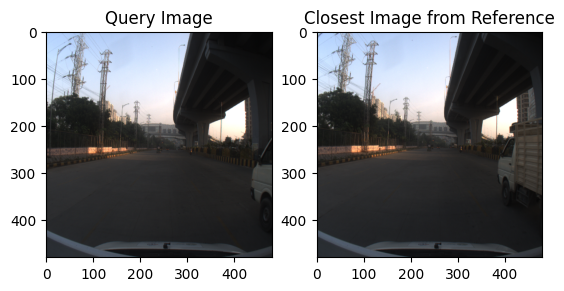

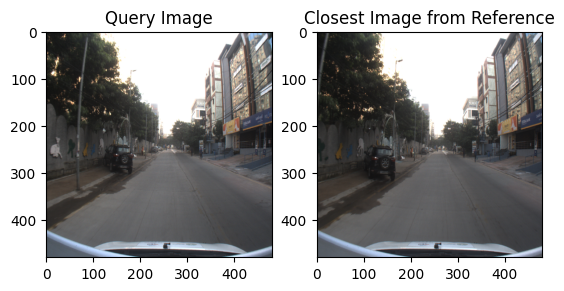

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.models as models
import keras.utils as image
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances
import torch
import torch.nn as nn
from skimage import data
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import euclidean_distances
from skimage import color
from skimage.feature import hog

class PartialNet(nn.Module):
    def __init__(self, len_hog_vector):
        super(PartialNet, self).__init__()
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 53 * 53, 4096)
        self.fc2 = nn.Linear(4096, len_hog_vector)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        return x

partial_model = PartialNet(441)

print(partial_model)
#partial_model.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_441_v2.pth"))
partial_model.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_441_v2.pth"))
partial_model.eval()

def numerical_sort(value):
    parts = value.split('.')
    return int(parts[0])

class Features:
    # Constructor method
    def __init__(self, coordinate, feature):
        self.coordinate = coordinate  # Instance variable
        self.feature = feature    # Instance variable

tensor_transform = transforms.Compose([transforms.ToTensor()])
def extract_features(input_image):
    image = cv2.imread(input_image, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(image, (224, 224))
    #input_set = [resized_img]
    #input_set = tf.convert_to_tensor(input_set, dtype=tf.int16)
    #print(input_set)
    with torch.no_grad():
      hog_pred = partial_model(tensor_transform(resized_img).view(1,3,224,224))
    #hog_pred = torch.flatten(hog_pred, 1)
    #geo = csv_dict[input_image.removeprefix(reference_folder + '/')]
    geo = csv_dict[input_image.removeprefix(query_folder + '/')]
    return Features(geo, hog_pred.detach().numpy())

'''
def find_hog(image):
    input_image = cv2.imread(image, cv2.IMREAD_COLOR)
    #input_image = tf.image.resize(input_image, (256, 256))
    resized_img = color.rgb2gray(input_image)
    fd = hog(resized_img, orientations=9, pixels_per_cell=(32, 32), cells_per_block=(1, 1))
    return fd.reshape(1, 441)
'''
reference_folder = '/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset'

files = os.listdir(reference_folder)
##sorted_files = sorted(files, key=numerical_sort)
##files = sorted_files[0:2501]

# Reference dataset (database) images
reference_images = [os.path.join(reference_folder, file) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

'''
# Extract features from reference images
reference_features = [extract_features(image_path) for image_path in reference_images]
#reference_features = [find_hog(image_path) for image_path in reference_images]

np.save('drive/MyDrive/Thesis/VPR_India/reference_features_hog_simple_441_v2_hog_vector.npy', reference_features)
'''

reference_features = np.load('drive/MyDrive/Thesis/VPR_India/reference_features_hog_simple_441_v2_hog_vector.npy', allow_pickle=True)
#reference_features = reference_features.reshape(8000, 1, 1764)
print (reference_features.shape)

# Query image
query_folder = '/content/drive/MyDrive/Thesis/VPR_India/Query_dataset'
#query_folder = 'drive/MyDrive/Thesis/Nordland/Summer'

files = os.listdir(query_folder)
#sorted_files = sorted(files, key=numerical_sort)
#files = sorted_files[6000:8000]

correct_predictions = 0
i = 1
correct_image_pair_predictions = []
incorrect_image_pair_predictions = []
# Extract features from query image
for query_image in files:
    file = query_image
    query_image = os.path.join(query_folder, query_image)
    query_features = extract_features(query_image)
    #query_features = find_hog(query_image)
    #query_features = query_features.reshape(1, 1764)

    # Calculate Euclidean distances between query features and reference features
    #query_index = int(file.rstrip(".png"))
    distances = [euclidean_distances(query_features.feature, ref_features.feature)[0][0] for ref_features in reference_features]

    # Find the index of the closest image (smallest distance)
    closest_index = np.argmin(distances)
    closest_image_path = reference_images[closest_index]
    print(query_image)
    print(closest_image_path)
    print(query_features.coordinate)
    print(reference_features[closest_index].coordinate)
    #if abs(query_index - start - closest_index) <= 5:

    #if abs(query_index - closest_index - 6000) <= 3:
    #   correct_predictions += 1
    #    correct_image_pair_predictions.append([query_image , closest_image_path])
    #else:
    #    incorrect_image_pair_predictions.append([query_image , closest_image_path])

    if query_features.coordinate == reference_features[closest_index].coordinate:
        correct_predictions += 1
        correct_image_pair_predictions.append([query_image , closest_image_path])
    else:
        incorrect_image_pair_predictions.append([query_image , closest_image_path])
    print(correct_predictions)
    print(i)
    i += 1

print (correct_predictions)

# Display query and closest image
query_img = plt.imread(correct_image_pair_predictions[10][0])
closest_img = plt.imread(correct_image_pair_predictions[10][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()

# Display another query and closest image
query_img = plt.imread(correct_image_pair_predictions[50][0])
closest_img = plt.imread(correct_image_pair_predictions[50][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()


Streaming output truncated to the last 5000 lines.
1644
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870891672234857.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870897264811508.png
(17.4509164181709, 78.3632032334955)
(17.4522935463121, 78.3635118960901)
843
1645
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692871410354783077.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870942418686001.png
(17.4911648422769, 78.3533655545995)
(17.4553553518655, 78.3637897832408)
843
1646
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692871030333237440.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870957603898057.png
(17.4640805648103, 78.3671704469089)
(17.4565542198177, 78.3645467147581)
843
1647
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870741521925616.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870742120917197.png
(17.4468279613177, 78.352926710652)
(17.4468279613177, 

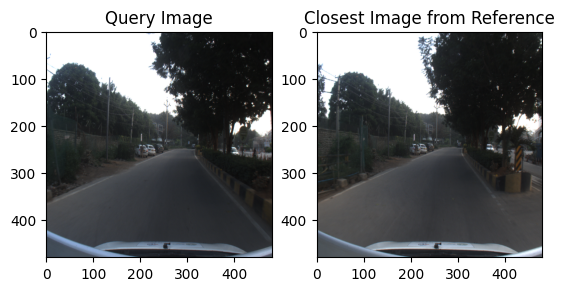

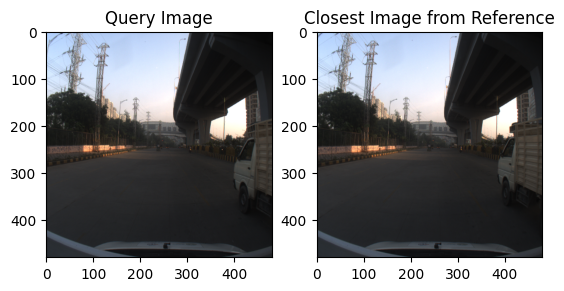

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.models as models
import keras.utils as image
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances
import torch
import torch.nn as nn
from skimage import data
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import euclidean_distances
from skimage import color
from skimage.feature import hog

class PartialNet(nn.Module):
    def __init__(self, len_hog_vector):
        super(PartialNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(30 * 30 * 32, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.hog_vector = nn.Linear(4096, len_hog_vector)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.pool3(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.hog_vector(x)
        return x

partial_model = PartialNet(1764)

print(partial_model)
#partial_model.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_3Conv3Pool_1764_v2.pth"), strict=False)
partial_model.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_3Conv3Pool_1764_v4.pth"))
partial_model.eval()

def numerical_sort(value):
    parts = value.split('.')
    return int(parts[0])

class Features:
    # Constructor method
    def __init__(self, coordinate, feature):
        self.coordinate = coordinate  # Instance variable
        self.feature = feature    # Instance variable

tensor_transform = transforms.Compose([transforms.ToTensor()])
def extract_features(input_image):
    image = cv2.imread(input_image, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(image, (256, 256))
    #input_set = [resized_img]
    #input_set = tf.convert_to_tensor(input_set, dtype=tf.int16)
    #print(input_set)
    with torch.no_grad():
      hog_pred = partial_model(tensor_transform(resized_img).view(1,3,256,256))
    #hog_pred = torch.flatten(hog_pred, 1)
    #geo = csv_dict[input_image.removeprefix(reference_folder + '/')]
    geo = csv_dict[input_image.removeprefix(query_folder + '/')]
    return Features(geo, hog_pred.detach().numpy())

'''
def find_hog(image):
    input_image = cv2.imread(image, cv2.IMREAD_COLOR)
    #input_image = tf.image.resize(input_image, (256, 256))
    resized_img = color.rgb2gray(input_image)
    fd = hog(resized_img, orientations=9, pixels_per_cell=(32, 32), cells_per_block=(1, 1))
    return fd.reshape(1, 441)
'''
reference_folder = '/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset'

files = os.listdir(reference_folder)
##sorted_files = sorted(files, key=numerical_sort)
##files = sorted_files[0:2501]

# Reference dataset (database) images
reference_images = [os.path.join(reference_folder, file) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

'''
# Extract features from reference images
reference_features = [extract_features(image_path) for image_path in reference_images]
#reference_features = [find_hog(image_path) for image_path in reference_images]

np.save('drive/MyDrive/Thesis/VPR_India/reference_features_hog_1764_v4_hog.npy', reference_features)
'''

reference_features = np.load('drive/MyDrive/Thesis/VPR_India/reference_features_hog_1764_v4_hog.npy', allow_pickle=True)
#reference_features = reference_features.reshape(8000, 1, 1764)
print (reference_features.shape)

# Query image
query_folder = '/content/drive/MyDrive/Thesis/VPR_India/Query_dataset'
#query_folder = 'drive/MyDrive/Thesis/Nordland/Summer'

files = os.listdir(query_folder)
#sorted_files = sorted(files, key=numerical_sort)
#files = sorted_files[6000:8000]

correct_predictions = 0
i = 1
correct_image_pair_predictions = []
incorrect_image_pair_predictions = []
# Extract features from query image
for query_image in files:
    file = query_image
    query_image = os.path.join(query_folder, query_image)
    query_features = extract_features(query_image)
    #query_features = find_hog(query_image)
    #query_features = query_features.reshape(1, 1764)

    # Calculate Euclidean distances between query features and reference features
    #query_index = int(file.rstrip(".png"))
    distances = [euclidean_distances(query_features.feature, ref_features.feature)[0][0] for ref_features in reference_features]

    # Find the index of the closest image (smallest distance)
    closest_index = np.argmin(distances)
    closest_image_path = reference_images[closest_index]
    print(query_image)
    print(closest_image_path)
    print(query_features.coordinate)
    print(reference_features[closest_index].coordinate)
    #if abs(query_index - start - closest_index) <= 5:

    #if abs(query_index - closest_index - 6000) <= 3:
    #   correct_predictions += 1
    #    correct_image_pair_predictions.append([query_image , closest_image_path])
    #else:
    #    incorrect_image_pair_predictions.append([query_image , closest_image_path])

    if query_features.coordinate == reference_features[closest_index].coordinate:
        correct_predictions += 1
        correct_image_pair_predictions.append([query_image , closest_image_path])
    else:
        incorrect_image_pair_predictions.append([query_image , closest_image_path])
    print(correct_predictions)
    print(i)
    i += 1

print (correct_predictions)

# Display query and closest image
query_img = plt.imread(correct_image_pair_predictions[10][0])
closest_img = plt.imread(correct_image_pair_predictions[10][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()

# Display another query and closest image
query_img = plt.imread(correct_image_pair_predictions[50][0])
closest_img = plt.imread(correct_image_pair_predictions[50][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()


Streaming output truncated to the last 5000 lines.
1763
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870772588788330.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870730530786904.png
(17.4485945630616, 78.3547563282777)
(17.4458731631036, 78.352471934286)
981
1764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870772489838517.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870790169881072.png
(17.4485945630616, 78.3547563282777)
(17.4486529814352, 78.3561306646507)
981
1765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870969593236695.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870969691892488.png
(17.457547389655, 78.3652372171607)
(17.457547389655, 78.3652372171607)
982
1766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/16928707248

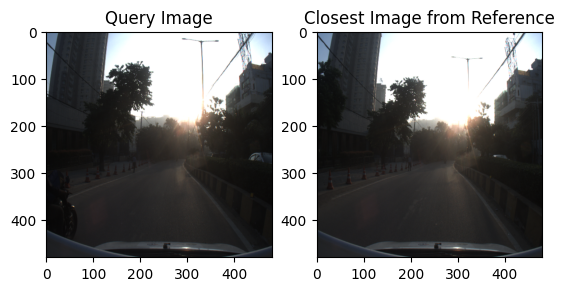

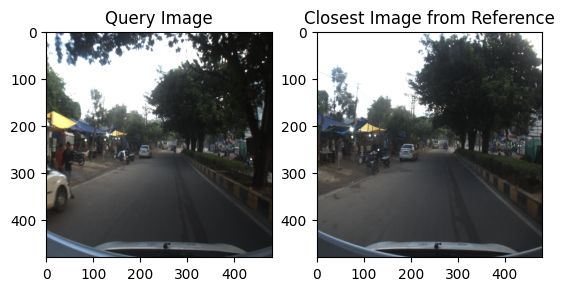

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.models as models
import keras.utils as image
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances
import torch
import torch.nn as nn
from skimage import data
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import euclidean_distances
from skimage import color
from skimage.feature import hog

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten

class Features:
    # Constructor method
    def __init__(self, coordinate, feature):
        self.coordinate = coordinate  # Instance variable
        self.feature = feature    # Instance variable

mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vpr_model = Model(inputs=mobilenet_model.input, outputs=Flatten()(mobilenet_model.get_layer('conv_pw_13_relu').output))

def extract_features(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    features = vpr_model.predict(img_array)
    #print(image_path)
    #geo = csv_dict[image_path.removeprefix(reference_folder + '/')]
    geo = csv_dict[image_path.removeprefix(query_folder + '/')]
    return Features(geo, features)


reference_folder = '/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset'

files = os.listdir(reference_folder)
##sorted_files = sorted(files, key=numerical_sort)
##files = sorted_files[0:2501]

# Reference dataset (database) images
reference_images = [os.path.join(reference_folder, file) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

'''
# Extract features from reference images
reference_features = [extract_features(image_path) for image_path in reference_images]
#reference_features = [find_hog(image_path) for image_path in reference_images]

np.save('drive/MyDrive/Thesis/VPR_India/reference_features_mobileNet.npy', reference_features)
'''

reference_features = np.load('drive/MyDrive/Thesis/VPR_India/reference_features_mobileNet.npy', allow_pickle=True)
#reference_features = reference_features.reshape(8000, 1, 1764)
print (reference_features.shape)

# Query image
query_folder = '/content/drive/MyDrive/Thesis/VPR_India/Query_dataset'
#query_folder = 'drive/MyDrive/Thesis/Nordland/Summer'

files = os.listdir(query_folder)
#sorted_files = sorted(files, key=numerical_sort)
#files = sorted_files[6000:8000]

correct_predictions = 0
i = 1
correct_image_pair_predictions = []
incorrect_image_pair_predictions = []
# Extract features from query image
for query_image in files:
    file = query_image
    query_image = os.path.join(query_folder, query_image)
    query_features = extract_features(query_image)
    #query_features = find_hog(query_image)
    #query_features = query_features.reshape(1, 1764)

    # Calculate Euclidean distances between query features and reference features
    #query_index = int(file.rstrip(".png"))
    distances = [euclidean_distances(query_features.feature, ref_features.feature)[0][0] for ref_features in reference_features]

    # Find the index of the closest image (smallest distance)
    closest_index = np.argmin(distances)
    closest_image_path = reference_images[closest_index]
    print(query_image)
    print(closest_image_path)
    print(query_features.coordinate)
    print(reference_features[closest_index].coordinate)
    #if abs(query_index - start - closest_index) <= 5:

    #if abs(query_index - closest_index - 6000) <= 3:
    #    correct_predictions += 1
    #    correct_image_pair_predictions.append([query_image , closest_image_path])
    #else:
    #    incorrect_image_pair_predictions.append([query_image , closest_image_path])

    if query_features.coordinate == reference_features[closest_index].coordinate:
        correct_predictions += 1
        correct_image_pair_predictions.append([query_image , closest_image_path])
    else:
        incorrect_image_pair_predictions.append([query_image , closest_image_path])
    print(correct_predictions)
    print(i)
    i += 1

print (correct_predictions)

# Display query and closest image
query_img = plt.imread(correct_image_pair_predictions[10][0])
closest_img = plt.imread(correct_image_pair_predictions[10][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()

# Display another query and closest image
query_img = plt.imread(correct_image_pair_predictions[50][0])
closest_img = plt.imread(correct_image_pair_predictions[50][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()


Streaming output truncated to the last 5000 lines.
1763
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870772588788330.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870758303966794.png
(17.4485945630616, 78.3547563282777)
(17.4481826175364, 78.3538731397936)
959
1764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870772489838517.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870758303966794.png
(17.4485945630616, 78.3547563282777)
(17.4481826175364, 78.3538731397936)
959
1765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/1692870969593236695.png
/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset/1692870969691892488.png
(17.457547389655, 78.3652372171607)
(17.457547389655, 78.3652372171607)
960
1766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
/content/drive/MyDrive/Thesis/VPR_India/Query_dataset/16928707248

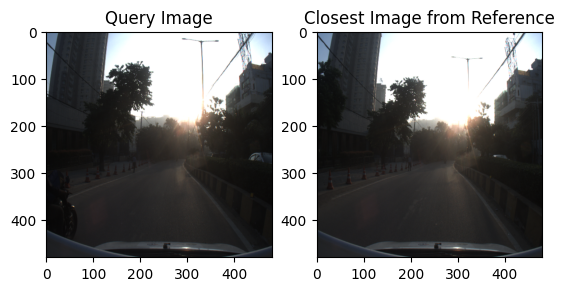

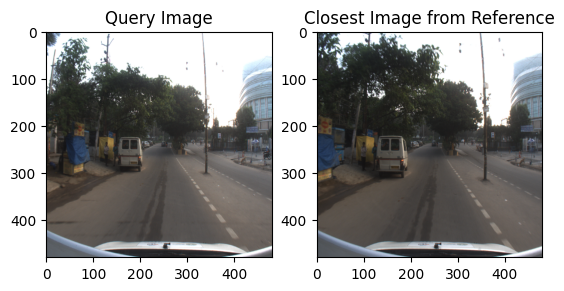

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.models as models
import keras.utils as image
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances
from skimage import data
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import euclidean_distances
from skimage import color
from skimage.feature import hog

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten

class Features:
    # Constructor method
    def __init__(self, coordinate, feature):
        self.coordinate = coordinate  # Instance variable
        self.feature = feature    # Instance variable

base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
vpr_model = Model(inputs=base_model.input, outputs=Flatten()(base_model.get_layer('block5_pool').output))

def extract_features(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    features = vpr_model.predict(img_array)
    #print(image_path)
    #geo = csv_dict[image_path.removeprefix(reference_folder + '/')]
    geo = csv_dict[image_path.removeprefix(query_folder + '/')]
    return Features(geo, features)


reference_folder = '/content/drive/MyDrive/Thesis/VPR_India/Reference_dataset'

files = os.listdir(reference_folder)
##sorted_files = sorted(files, key=numerical_sort)
##files = sorted_files[0:2501]

# Reference dataset (database) images
reference_images = [os.path.join(reference_folder, file) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

'''
# Extract features from reference images
reference_features = [extract_features(image_path) for image_path in reference_images]
#reference_features = [find_hog(image_path) for image_path in reference_images]

np.save('drive/MyDrive/Thesis/VPR_India/reference_features_vgg16_pool5.npy', reference_features)
'''

reference_features = np.load('drive/MyDrive/Thesis/VPR_India/reference_features_vgg16_pool5.npy', allow_pickle=True)
#reference_features = reference_features.reshape(8000, 1, 1764)
print (reference_features.shape)

# Query image
query_folder = '/content/drive/MyDrive/Thesis/VPR_India/Query_dataset'
#query_folder = 'drive/MyDrive/Thesis/Nordland/Summer'

files = os.listdir(query_folder)
#sorted_files = sorted(files, key=numerical_sort)
#files = sorted_files[6000:8000]

correct_predictions = 0
i = 1
correct_image_pair_predictions = []
incorrect_image_pair_predictions = []
# Extract features from query image
for query_image in files:
    file = query_image
    query_image = os.path.join(query_folder, query_image)
    query_features = extract_features(query_image)
    #query_features = find_hog(query_image)
    #query_features = query_features.reshape(1, 1764)

    # Calculate Euclidean distances between query features and reference features
    #query_index = int(file.rstrip(".png"))
    distances = [euclidean_distances(query_features.feature, ref_features.feature)[0][0] for ref_features in reference_features]

    # Find the index of the closest image (smallest distance)
    closest_index = np.argmin(distances)
    closest_image_path = reference_images[closest_index]
    print(query_image)
    print(closest_image_path)
    print(query_features.coordinate)
    print(reference_features[closest_index].coordinate)
    #if abs(query_index - start - closest_index) <= 5:

    #if abs(query_index - closest_index - 6000) <= 3:
    #    correct_predictions += 1
    #    correct_image_pair_predictions.append([query_image , closest_image_path])
    #else:
    #    incorrect_image_pair_predictions.append([query_image , closest_image_path])

    if query_features.coordinate == reference_features[closest_index].coordinate:
        correct_predictions += 1
        correct_image_pair_predictions.append([query_image , closest_image_path])
    else:
        incorrect_image_pair_predictions.append([query_image , closest_image_path])
    print(correct_predictions)
    print(i)
    i += 1

print (correct_predictions)

# Display query and closest image
query_img = plt.imread(correct_image_pair_predictions[10][0])
closest_img = plt.imread(correct_image_pair_predictions[10][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()

# Display another query and closest image
query_img = plt.imread(correct_image_pair_predictions[50][0])
closest_img = plt.imread(correct_image_pair_predictions[50][1])

plt.subplot(1, 2, 1)
plt.imshow(query_img)
plt.title('Query Image')

plt.subplot(1, 2, 2)
plt.imshow(closest_img)
plt.title('Closest Image from Reference')

plt.show()
